In [1]:
import collections
import itertools
import logging
import os
import shelve

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from functools import partial
from multiprocessing import Pool

from gensim import corpora, models
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics

from nltools.exceptions import WrongExtensionError
from nltools.streams.io_.basic import read_csv
from nltools.streams.preprocessing import basic as basic_prp
from nltools.streams.preprocessing.preloading import stop_words
from nltools.streams.preprocessing import w2v

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Предобработка данных

In [2]:
def preprocess(text, stop_words=None, min_len=1):
    # text = basic_prp.clean_text(text)
    return basic_prp.tokenize(text, stop_words, min_len)


def tm_preprocess(text):
    morph = pymorphy2.MorphAnalyzer()
    return [basic_prp.lemmatize(i, morph) for i in text]

#     preprocess(text, stop_words=stop_words, min_len=min_len)

def d2v_read_preprocess(input_file):
    cur_document = [preprocess(line, stop_words=stop_words, min_len=0) for *_, line in read_csv(f'tg_data/{input_file}', msg_brd=None)]            
    return list(itertools.chain(*cur_document)), [input_file]
    
    
def tm_read_preprocess(input_file):    
    cur_document = [tm_preprocess(line, stop_words=stop_words, min_len=0) for *_, line in read_csv(f'tg_data/{input_file}', msg_brd=None)]            
    return list(itertools.chain(*cur_document))

        
def read_preprocess_multi(input_files,
                          prp_fxn,
                          batch_size=5, 
                          workers=5,
                          db_name='temp.db',
                          res_var_name='train_corpus'):
    
    for i in range(0, len(input_files), batch_size):
        print(f'\rPreprocessing files {i}-{i+batch_size}.', end='')
        pool = Pool(processes=workers)
        batch = list(pool.map(prp_fxn, input_files[i:i+batch_size]))
        pool.close()
        pool.join()

        with shelve.open(db_name) as db:
            try:
                temp = db[res_var_name]
            except KeyError:
                db[res_var_name] = batch
                continue

            temp += batch
            db[res_var_name] = temp
            del temp, batch


In [3]:
read_preprocess_multi(list(os.listdir('tg_data/')), 
                      prp_fxn=d2v_read_preprocess,
                      db_name='objs/temp-d2v-no-re.db', 
                      res_var_name='train_corpus')

Preprocessing files 160-165.

In [ ]:
read_preprocess_multi(list(os.listdir('tg_data/')), 
                      prp_fxn=tm_read_preprocess,
                      db_name='objs/temp-tm.db', 
                      res_var_name='train_corpus')

# Чтение предобработанных данных для D2V

In [15]:
class ShelveReader:
    def __init__(self, filenames, mode='td'):
        self.filenames = filenames
        self.mode = mode
        
    def __iter__(self):
        for fn in self.filenames:
            with shelve.open(fn) as db:
                for doc, label in db[list(db.keys())[0]]:
                    if self.mode == 'td':
                        yield models.doc2vec.TaggedDocument(doc, label)  
                    elif self.mode == 'asis':
                        yield doc

In [3]:
train_corpus = [doc for doc in ShelveReader(['objs/temp-d2v-no-of.db'])]

# Doc2Vec
## Создание и обучение модели

In [4]:
%%time
model = models.doc2vec.Doc2Vec(vector_size=244, dm_mean=0, min_count=1, window=9, sample=1e-5, workers=4, seed=42)
model.build_vocab(train_corpus)

2018-04-17 19:07:50,679 : INFO : collecting all words and their counts
2018-04-17 19:07:50,681 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-04-17 19:08:02,557 : INFO : collected 1290932 word types and 162 unique tags from a corpus of 162 examples and 51485652 words
2018-04-17 19:08:02,557 : INFO : Loading a fresh vocabulary
2018-04-17 19:08:14,277 : INFO : min_count=1 retains 1290932 unique words (100% of original 1290932, drops 0)
2018-04-17 19:08:14,278 : INFO : min_count=1 leaves 51485652 word corpus (100% of original 51485652, drops 0)
2018-04-17 19:08:17,987 : INFO : deleting the raw counts dictionary of 1290932 items
2018-04-17 19:08:18,033 : INFO : sample=1e-05 downsamples 2180 most-common words
2018-04-17 19:08:18,034 : INFO : downsampling leaves estimated 17322977 word corpus (33.6% of prior 51485652)
2018-04-17 19:08:22,166 : INFO : estimated required memory for 1290932 words and 244 dimensions: 3165555776 bytes
2018-04-17 19:08:22,167 

CPU times: user 46.8 s, sys: 601 ms, total: 47.4 s
Wall time: 47.4 s


In [5]:
%%time
model.train(train_corpus, 
            total_examples=model.corpus_count,
            epochs=1)

2018-04-17 19:08:38,070 : INFO : training model with 4 workers on 1290932 vocabulary and 244 features, using sg=0 hs=0 sample=1e-05 negative=5 window=9
2018-04-17 19:08:39,074 : INFO : EPOCH 1 - PROGRESS: at 9.88% examples, 155283 words/s, in_qsize 8, out_qsize 1
2018-04-17 19:08:40,088 : INFO : EPOCH 1 - PROGRESS: at 24.07% examples, 188992 words/s, in_qsize 7, out_qsize 0
2018-04-17 19:08:41,098 : INFO : EPOCH 1 - PROGRESS: at 40.12% examples, 211087 words/s, in_qsize 8, out_qsize 0
2018-04-17 19:08:42,111 : INFO : EPOCH 1 - PROGRESS: at 55.56% examples, 218724 words/s, in_qsize 8, out_qsize 0
2018-04-17 19:08:43,147 : INFO : EPOCH 1 - PROGRESS: at 72.84% examples, 228175 words/s, in_qsize 7, out_qsize 0
2018-04-17 19:08:44,189 : INFO : EPOCH 1 - PROGRESS: at 90.12% examples, 234082 words/s, in_qsize 7, out_qsize 0
2018-04-17 19:08:44,719 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-17 19:08:44,722 : INFO : worker thread finished; awaiting finish of 2 mo

CPU times: user 17.9 s, sys: 1.65 s, total: 19.6 s
Wall time: 6.73 s


## Проверка на вменяемость для Doc2Vec модели 

In [6]:
def get_ranks(train_corpus):
    ranks = []

    for doc in train_corpus:
        inferred_vector = model.infer_vector(doc.words)
        sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
        rank = [docid for docid, sim in sims].index(doc.tags[0])
        ranks.append(rank)
    
    return collections.Counter(ranks)

In [7]:
%%time
get_ranks(train_corpus)

2018-04-17 19:08:45,063 : INFO : precomputing L2-norms of doc weight vectors


CPU times: user 1min 16s, sys: 2.55 s, total: 1min 18s
Wall time: 47.8 s


Counter({0: 12,
         1: 1,
         2: 1,
         4: 1,
         7: 1,
         8: 2,
         9: 3,
         11: 1,
         12: 1,
         13: 2,
         14: 1,
         15: 2,
         16: 1,
         17: 2,
         19: 1,
         20: 1,
         21: 2,
         23: 3,
         24: 2,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 2,
         31: 2,
         32: 1,
         33: 1,
         34: 2,
         35: 2,
         36: 1,
         37: 1,
         38: 5,
         41: 2,
         42: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 2,
         48: 1,
         49: 2,
         51: 1,
         52: 3,
         53: 2,
         54: 2,
         58: 1,
         59: 1,
         60: 1,
         61: 1,
         63: 1,
         64: 1,
         65: 2,
         66: 3,
         67: 1,
         69: 1,
         70: 1,
         72: 1,
         73: 2,
         75: 1,
         76: 1,
         77: 1,
         78: 2,
         79: 2,
         81: 2

In [8]:
model.save('d2v-215-no-of')

2018-04-17 19:09:32,711 : INFO : saving Doc2Vec object under d2v-215-no-of, separately None
2018-04-17 19:09:32,712 : INFO : storing np array 'syn1neg' to d2v-215-no-of.trainables.syn1neg.npy
2018-04-17 19:09:36,343 : INFO : storing np array 'vectors' to d2v-215-no-of.wv.vectors.npy
2018-04-17 19:09:44,942 : INFO : saved d2v-215-no-of


In [9]:
del model

## Проверка результатов векторизации путем проведения кластеризации и отрисовки векторов в сжатом пространстве

In [2]:
true_labels_df = pd.read_csv('dss/ds_true.csv')
true_labels = [j-1 for i in range(len(true_labels_df)) for j, el in enumerate(true_labels_df.iloc[i]) if el == 1]

In [3]:
model = models.doc2vec.Doc2Vec.load('d2v-215-no-of')

2018-04-23 21:12:28,747 : INFO : loading Doc2Vec object from d2v-215-no-of
2018-04-23 21:12:31,947 : INFO : loading vocabulary recursively from d2v-215-no-of.vocabulary.* with mmap=None
2018-04-23 21:12:31,948 : INFO : loading trainables recursively from d2v-215-no-of.trainables.* with mmap=None
2018-04-23 21:12:31,948 : INFO : loading syn1neg from d2v-215-no-of.trainables.syn1neg.npy with mmap=None
2018-04-23 21:12:34,261 : INFO : loading wv recursively from d2v-215-no-of.wv.* with mmap=None
2018-04-23 21:12:34,262 : INFO : loading vectors from d2v-215-no-of.wv.vectors.npy with mmap=None
2018-04-23 21:12:36,596 : INFO : loading docvecs recursively from d2v-215-no-of.docvecs.* with mmap=None
2018-04-23 21:12:36,596 : INFO : loaded d2v-215-no-of


In [4]:
doc_vectors = []

for fname in true_labels_df['dump_id']:
    doc_vectors.append(model.docvecs[fname].reshape(-1, 1))

In [205]:
kmeans = KMeans(n_clusters=8, random_state=42)
pred_labels_kmeans = kmeans.fit_predict(model.docvecs.vectors_docs)
metrics.fowlkes_mallows_score(true_labels, pred_labels_kmeans)  

0.5219330806849355

In [5]:
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture

gamma 0.458

In [201]:
pred_labels_agg = AgglomerativeClustering(linkage="average", n_clusters=8).fit_predict(model.docvecs.vectors_docs)
metrics.fowlkes_mallows_score(true_labels, pred_labels_agg)

0.6344804539287682

In [184]:
gmm = GaussianMixture(n_components=8, covariance_type='spherical', tol=200, random_state=1).fit(model.docvecs.vectors_docs)
pred_labels_gmm = gmm.predict(model.docvecs.vectors_docs)
metrics.fowlkes_mallows_score(true_labels, pred_labels_gmm)

0.6546546310278596

In [23]:
parameters = {'gamma': [0.458]}
res = []

for gamma in parameters['gamma']:
#     for min_samples in parameters['min_samples']:      
    pred_labels_sc = SpectralClustering(n_clusters=8, random_state=42, gamma=gamma).fit_predict(model.docvecs.vectors_docs)
    res.append(metrics.fowlkes_mallows_score(true_labels, pred_labels_sc))
        
print(max(res))

0.7010997054789243


In [88]:
pred_labels_sc = SpectralClustering(n_clusters=8, random_state=42, gamma=0.5).fit_predict(model.docvecs.vectors_docs)
metrics.fowlkes_mallows_score(true_labels, pred_labels_sc)

0.5255284828849759

In [81]:
parameters = {'eps': np.arange(0.01, 10, 0.01), 'min_samples': np.arange(1, 15)}
res = []

for eps in parameters['eps']:
    for min_samples in parameters['min_samples']:      
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(model.docvecs.vectors_docs)
        pred_labels_dbscan = dbscan.labels_
        res.append(metrics.fowlkes_mallows_score(true_labels, pred_labels_dbscan))
        
print(max(res))

0.5458101370278097


model = Doc2Vec(vector_size=244, min_count=15, window=10, sample=1e-5, workers=4, seed=42) -- 0.5112838009575723

model = Doc2Vec(vector_size=244, min_count=1, window=10, sample=1e-5, workers=4, seed=42) -- 0.5571674415966767

model = Doc2Vec(vector_size=244, dm_mean=0, min_count=1, window=10, sample=1e-5, workers=4, seed=42) -- 0.5948256499035022

model = Doc2Vec(vector_size=244, dm_mean=0, min_count=1, window=10, sample=1e-5, workers=4, seed=42) -- 0.5415875549633792

model = Doc2Vec(vector_size=244, dm_mean=0, min_count=1, window=9, sample=1e-5, workers=4, seed=42) -- 0.6189792071441661

### Отрисовка векторов (PCA)

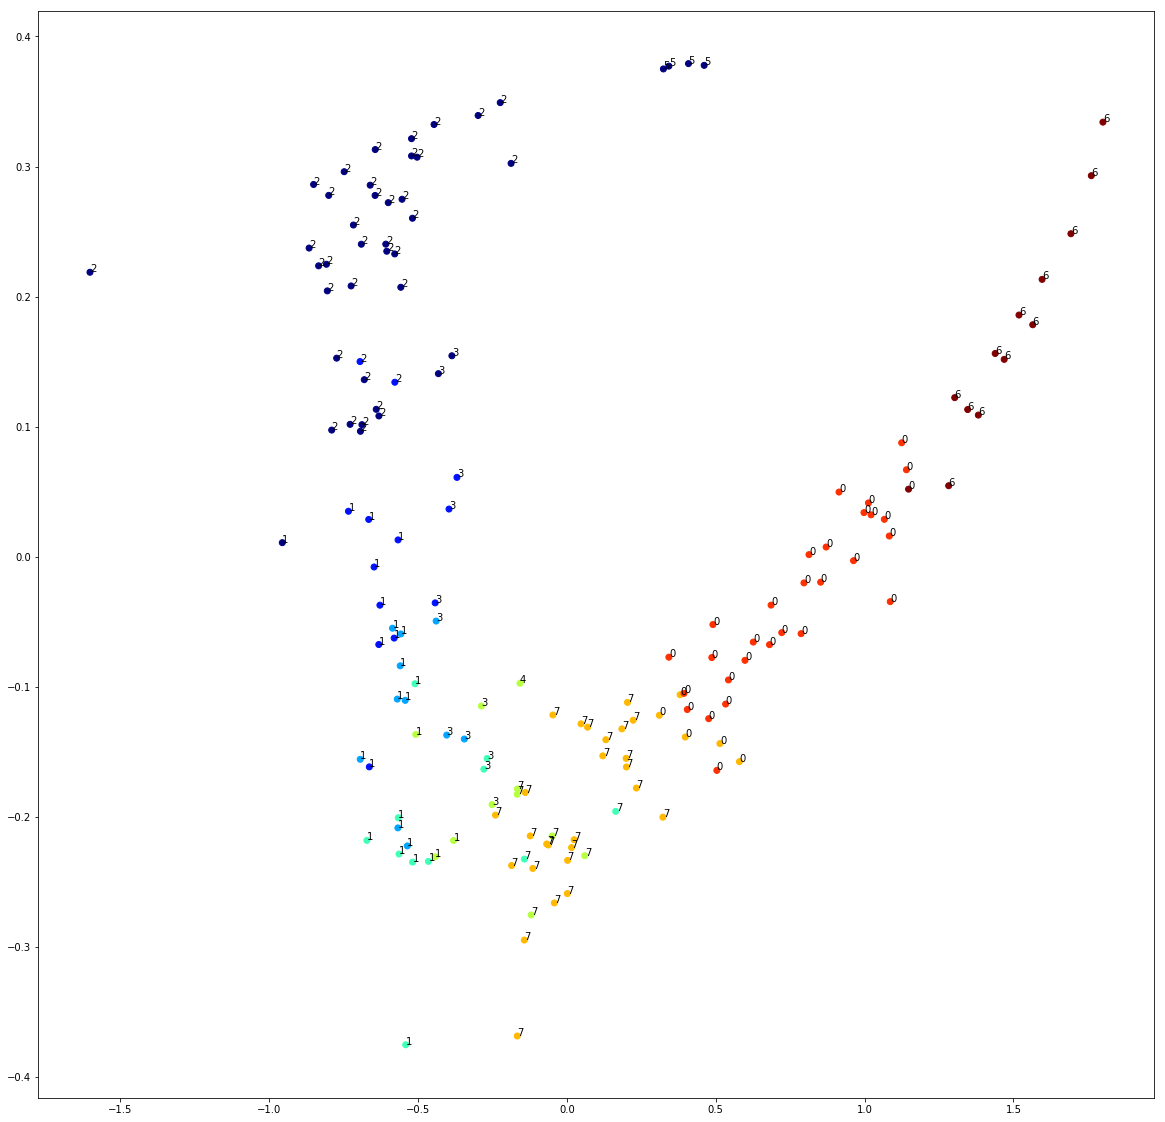

In [204]:
pca = PCA(n_components=2)
X = pca.fit_transform(model.docvecs.vectors_docs)

plt.figure(figsize=(20, 20))
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='jet')

for label, x, y in zip(pred_labels_sc, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

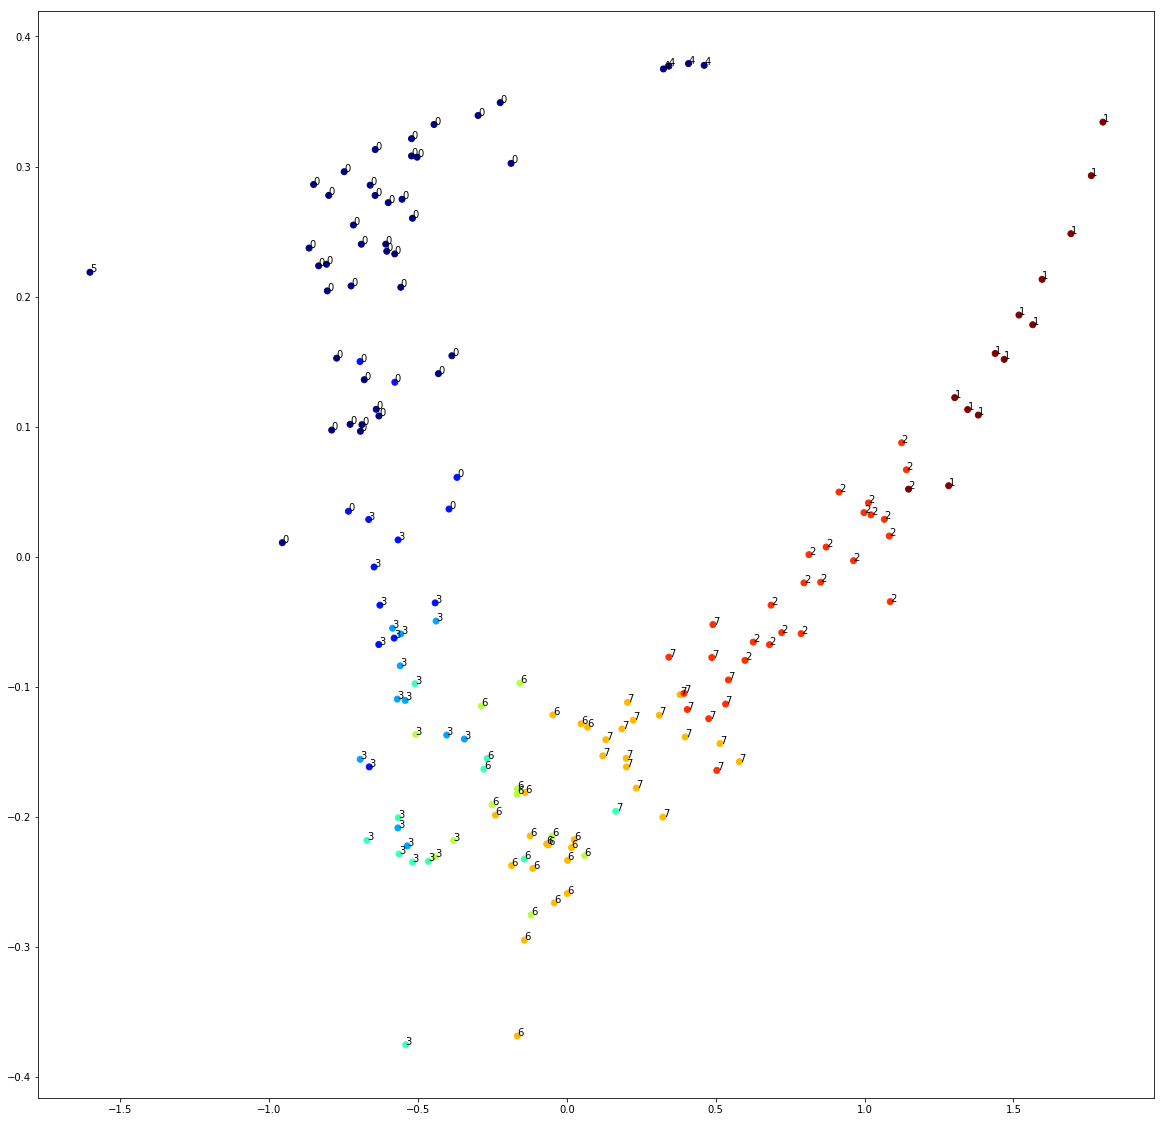

In [202]:
pca = PCA(n_components=2)
X = pca.fit_transform(model.docvecs.vectors_docs)

plt.figure(figsize=(20, 20))
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='jet')

for label, x, y in zip(pred_labels_agg, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

### Отрисовка векторов (TSNE)

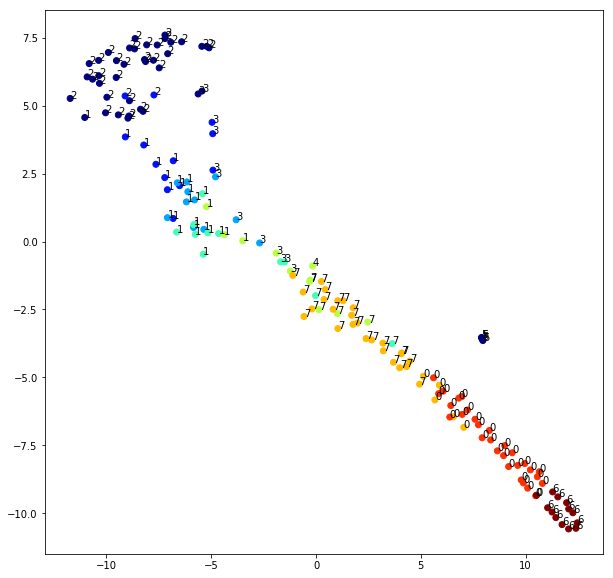

In [206]:
X = TSNE(n_components=2).fit_transform(model.docvecs.vectors_docs)

plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='jet')

for label, x, y in zip(pred_labels_sc, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

In [272]:
del model, X, train_corpus, true_labels

# Тематическое моделирование

In [31]:
train_corpus = [doc for doc in ShelveReader(['objs/temp-d2v.db'], mode='asis')]

In [18]:
dct = corpora.Dictionary(train_corpus)
corpus = [dct.doc2bow(line) for line in train_corpus]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

2018-04-16 13:53:10,486 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-16 13:54:03,188 : INFO : built Dictionary(1162293 unique tokens: [' ', '  ', '   ', '    ', '     ']...) from 162 documents (total 50365660 corpus positions)
2018-04-16 13:54:38,893 : INFO : collecting document frequencies
2018-04-16 13:54:38,894 : INFO : PROGRESS: processing document #0
2018-04-16 13:54:41,252 : INFO : calculating IDF weights for 162 documents and 1162292 features (4983554 matrix non-zeros)


In [19]:
lsi = models.LsiModel(corpus_tfidf, id2word=dct, num_topics=8)

2018-04-16 13:54:44,589 : INFO : using serial LSI version on this node
2018-04-16 13:54:44,594 : INFO : updating model with new documents
2018-04-16 13:55:18,308 : INFO : preparing a new chunk of documents
2018-04-16 13:55:21,112 : INFO : using 100 extra samples and 2 power iterations
2018-04-16 13:55:21,113 : INFO : 1st phase: constructing (1162293, 108) action matrix
2018-04-16 13:55:24,125 : INFO : orthonormalizing (1162293, 108) action matrix
2018-04-16 13:56:20,841 : INFO : 2nd phase: running dense svd on (108, 162) matrix
2018-04-16 13:56:21,702 : INFO : computing the final decomposition
2018-04-16 13:56:21,703 : INFO : keeping 8 factors (discarding 79.451% of energy spectrum)
2018-04-16 13:56:22,107 : INFO : processed documents up to #162
2018-04-16 13:56:22,680 : INFO : topic #0(2.806): -0.065*"фильм" + -0.065*"биток" + -0.056*"тян" + -0.050*"юнити" + -0.048*"пс4" + -0.046*"кино" + -0.041*"аниме" + -0.040*"лол" + -0.039*"js" + -0.039*"покемонов"
2018-04-16 13:56:22,719 : INFO :

In [20]:
lsi.print_topics(8)

2018-04-16 13:56:23,262 : INFO : topic #0(2.806): -0.065*"фильм" + -0.065*"биток" + -0.056*"тян" + -0.050*"юнити" + -0.048*"пс4" + -0.046*"кино" + -0.041*"аниме" + -0.040*"лол" + -0.039*"js" + -0.039*"покемонов"
2018-04-16 13:56:23,310 : INFO : topic #1(1.774): 0.232*"биток" + -0.188*"гимы" + -0.161*"покемонов" + -0.151*"поков" + -0.140*"гим" + -0.127*"покемона" + -0.125*"гимов" + 0.110*"рипл" + 0.103*"битка" + -0.099*"люры"
2018-04-16 13:56:23,367 : INFO : topic #2(1.740): -0.293*"биток" + -0.145*"рипл" + -0.131*"битка" + -0.112*"btc" + -0.108*"эфир" + -0.101*"гимы" + -0.088*"памп" + 0.087*"js" + -0.086*"битки" + -0.085*"нэм"
2018-04-16 13:56:23,422 : INFO : topic #3(1.721): 0.174*"гимы" + 0.146*"покемонов" + 0.141*"поков" + 0.131*"гим" + 0.120*"покемона" + -0.118*"фильм" + 0.116*"гимов" + 0.090*"снорлакс" + 0.088*"гима" + 0.087*"люры"
2018-04-16 13:56:23,479 : INFO : topic #4(1.498): 0.173*"пс4" + 0.114*"3дс" + 0.101*"пс3" + 0.101*"ханзо" + 0.100*"длц" + 0.095*"биток" + 0.095*"псн" +

[(0,
  '-0.065*"фильм" + -0.065*"биток" + -0.056*"тян" + -0.050*"юнити" + -0.048*"пс4" + -0.046*"кино" + -0.041*"аниме" + -0.040*"лол" + -0.039*"js" + -0.039*"покемонов"'),
 (1,
  '0.232*"биток" + -0.188*"гимы" + -0.161*"покемонов" + -0.151*"поков" + -0.140*"гим" + -0.127*"покемона" + -0.125*"гимов" + 0.110*"рипл" + 0.103*"битка" + -0.099*"люры"'),
 (2,
  '-0.293*"биток" + -0.145*"рипл" + -0.131*"битка" + -0.112*"btc" + -0.108*"эфир" + -0.101*"гимы" + -0.088*"памп" + 0.087*"js" + -0.086*"битки" + -0.085*"нэм"'),
 (3,
  '0.174*"гимы" + 0.146*"покемонов" + 0.141*"поков" + 0.131*"гим" + 0.120*"покемона" + -0.118*"фильм" + 0.116*"гимов" + 0.090*"снорлакс" + 0.088*"гима" + 0.087*"люры"'),
 (4,
  '0.173*"пс4" + 0.114*"3дс" + 0.101*"пс3" + 0.101*"ханзо" + 0.100*"длц" + 0.095*"биток" + 0.095*"псн" + 0.092*"киря" + 0.087*"ивус" + 0.082*"фпс"'),
 (5,
  '0.239*"фильм" + 0.156*"кино" + 0.131*"смотрела" + 0.110*"фильма" + 0.095*"фугу" + 0.090*"фильмы" + 0.086*"фильмов" + 0.083*"трейлер" + 0.080*"фи

# Word2Vec
## Создание и обучение модели

In [16]:
del train_corpus, model

In [17]:
train_corpus = [doc for doc in ShelveReader(['objs/temp-d2v-no-of.db'], mode='asis')]

In [18]:
dim = 300
model = models.word2vec.Word2Vec(train_corpus,
                                 size=dim,
                                 min_count=1,
                                 workers=4,
                                 window=15,
                                 sample=1e-5,
                                 seed=42,
                                 iter=1)

2018-04-18 13:32:15,041 : INFO : collecting all words and their counts
2018-04-18 13:32:15,043 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-18 13:32:25,471 : INFO : collected 1290932 word types from a corpus of 51485652 raw words and 162 sentences
2018-04-18 13:32:25,472 : INFO : Loading a fresh vocabulary
2018-04-18 13:32:34,854 : INFO : min_count=1 retains 1290932 unique words (100% of original 1290932, drops 0)
2018-04-18 13:32:34,856 : INFO : min_count=1 leaves 51485652 word corpus (100% of original 51485652, drops 0)
2018-04-18 13:32:38,199 : INFO : deleting the raw counts dictionary of 1290932 items
2018-04-18 13:32:38,230 : INFO : sample=1e-05 downsamples 2180 most-common words
2018-04-18 13:32:38,231 : INFO : downsampling leaves estimated 17322977 word corpus (33.6% of prior 51485652)
2018-04-18 13:32:41,963 : INFO : estimated required memory for 1290932 words and 300 dimensions: 3743702800 bytes
2018-04-18 13:32:41,964 : INFO : resetting l

In [7]:
all_wvs = []

for i, doc in enumerate(train_corpus):
    print(f'\rProgress: {i+1}/{len(train_corpus)}', end='')
    cur_wv = w2v.get_aggregated_wvs(doc, 
                                    model.wv, 
                                    aggregate=sum, 
#                                     aggr_kwargs={'axis': 0},
                                    dim=dim)
    # cur_wv = cur_wv.reshape(1, -1)
    all_wvs.append(cur_wv)

Progress: 162/162

In [8]:
kmeans = KMeans(n_clusters=8, random_state=42)
pred_labels = kmeans.fit_predict(all_wvs)

In [11]:
metrics.fowlkes_mallows_score(true_labels, pred_labels)

0.25143613079245686

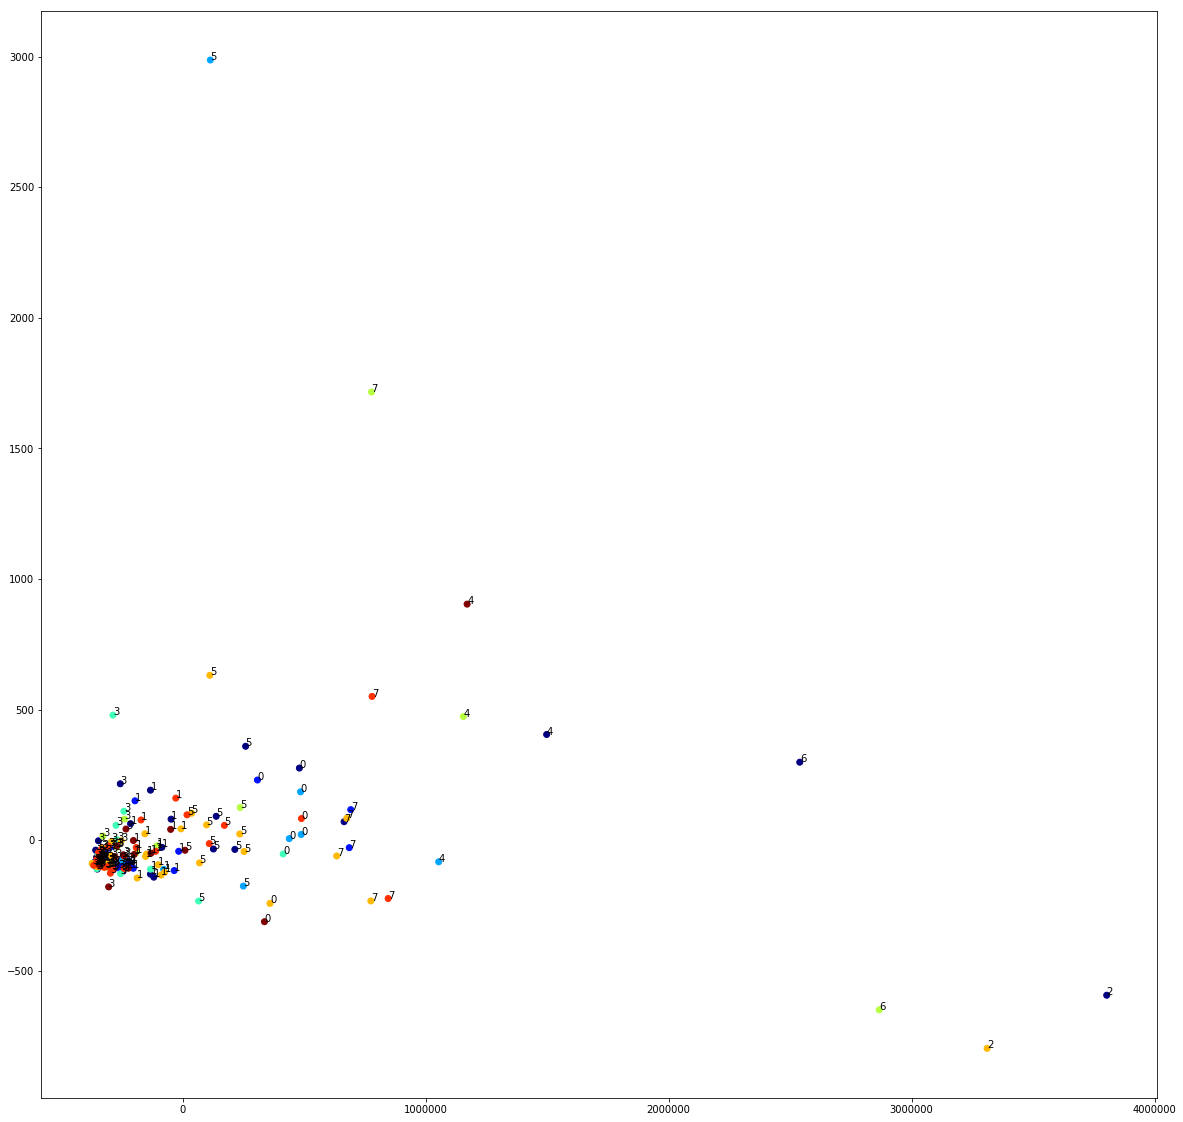

In [12]:
pca = PCA(n_components=2)
X = pca.fit_transform(all_wvs)

plt.figure(figsize=(20, 20))
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='jet')

for label, x, y in zip(pred_labels, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

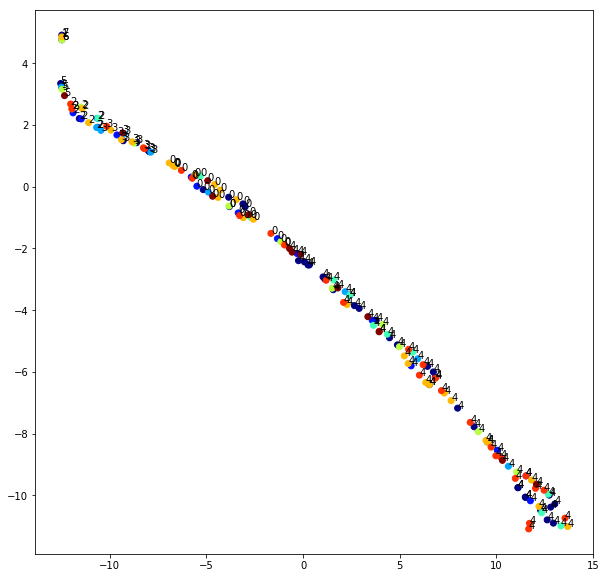

In [16]:
X = TSNE(n_components=2).fit_transform(all_wvs)

plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='jet')

for label, x, y in zip(pred_labels, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

In [ ]:
# test_cluster = [i for i in range(len(labels)) if labels[i] == 2]

# # for i in test_cluster:
# #     print(f'i:{i} {vld.iloc[i]["IT"]}')
# for i in range(43):
#     print(f'{labels[i]}')
# collections.Counter(labels)